Компания, которая разрабатывает мобильные игры, захотела создать функцию для подсчета retention пользователей

In [1]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

In [2]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-alekesej-chikin-xb-3434b/shared/problem1-reg_data.csv', sep = ';') # Данные о времени регистрации пользователей
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-alekesej-chikin-xb-3434b/shared/problem1-auth_data.csv', sep = ';') # Данные о времени захода пользователей в игру

In [3]:
# Получаем даты регистрации и захода пользователей
reg_data['date_reg']=pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['date_auth']=pd.to_datetime(auth_data['auth_ts'], unit='s')

In [4]:
# Объединяем датафреймы для дальнейшей работы с ними
full_data = auth_data.merge(
        reg_data.drop_duplicates(),
        on='uid',
        how='inner')
full_data.head()

,auth_ts,uid,date_auth,reg_ts,date_reg
0,911382223,1,1998-11-18 09:43:43,911382223,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09,932683089,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46,932683089,1999-07-22 22:38:09
3,933393015,2,1999-07-31 03:50:15,932683089,1999-07-22 22:38:09
4,933875379,2,1999-08-05 17:49:39,932683089,1999-07-22 22:38:09


Проведем предварительный анализ данных на предмет пропусков, дублей и для получения иной информации

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   auth_ts    int64         
 1   uid        int64         
 2   date_auth  datetime64[ns]
 3   reg_ts     int64         
 4   date_reg   datetime64[ns]
dtypes: datetime64[ns](2), int64(3)
memory usage: 439.5 MB


In [6]:
full_data.isna().sum()

auth_ts      0
uid          0
date_auth    0
reg_ts       0
date_reg     0
dtype: int64

In [10]:
full_data.duplicated().value_counts()

False    9601013
dtype: int64

Визуализируем данные для понимания их содержания

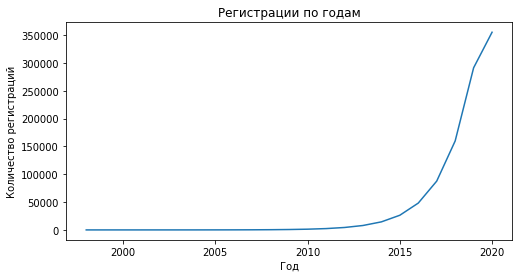

In [11]:
plt.figure(figsize=(8, 4))
reg_data['year'] = reg_data['date_reg'].dt.year
reg_data['year'].value_counts().sort_index().plot()
plt.title("Регистрации по годам")
plt.xlabel("Год")
plt.ylabel("Количество регистраций")
plt.show()

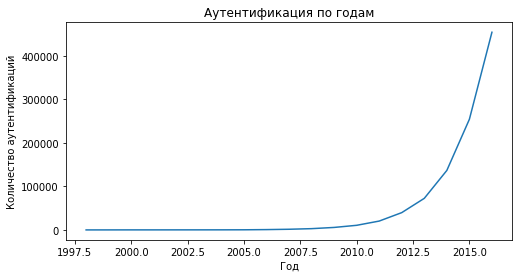

In [12]:
plt.figure(figsize=(8, 4))
reg_data['year'] = auth_data['date_auth'].dt.year
reg_data['year'].value_counts().sort_index().plot()
plt.title("Аутентификация по годам")
plt.xlabel("Год")
plt.ylabel("Количество аутентификаций")
plt.show()

In [13]:
# Напишем формулу расчета
# Зададим промежуток времени. Поскольку самое большое количество регистраций было в 2020 году, выберем его
start_date = '2020-01-01'
end_date = '2020-01-20'

def calculate_daily_retention(full_data, user_id_col='uid', registration_date_col='date_reg', activity_date_col='date_auth'):
     # Преобразуем даты в формат datetime
    full_data[registration_date_col] = pd.to_datetime(full_data[registration_date_col])
    full_data[activity_date_col] = pd.to_datetime(full_data[activity_date_col])
    
    # Фильтруем данные по диапазону дат, если указаны
    if start_date is not None:
        full_data = full_data[full_data[registration_date_col] >= pd.to_datetime(start_date)]
    if end_date is not None:
        full_data = full_data[full_data[registration_date_col] <= pd.to_datetime(end_date)]
    if end_date is not None:
        full_data = full_data[full_data[activity_date_col] <= pd.to_datetime(end_date)]
        
    # Преобразуем даты в период
    full_data[registration_date_col] = pd.to_datetime(full_data[registration_date_col])
    full_data[activity_date_col] = pd.to_datetime(full_data[activity_date_col])
    
    full_data['reg_period_day'] = full_data[registration_date_col].dt.to_period('D')
    full_data['activity_period_day'] = full_data[activity_date_col].dt.to_period('D')
    
    # Определяем день первой регистрации для каждого пользователя
    full_data['cohort_day'] = full_data.groupby(user_id_col)[registration_date_col].transform('min').dt.to_period('D')
    
    # Определяем номер периода (день) относительно дня регистрации
    full_data['period_number_day'] = (full_data['activity_period_day'] - full_data['cohort_day']).apply(attrgetter('n'))
    
    # Группируем данные по дням регистрации и периодам
    df_cohort = full_data.groupby(['cohort_day', 'period_number_day']).agg(n_users=(user_id_col, 'nunique')).reset_index()
        
    # Создаем сводную таблицу
    cohort_pivot = df_cohort.pivot_table(index='cohort_day', columns='period_number_day', values='n_users', fill_value=0)
    
    # Рассчитываем общее количество пользователей в каждой когорте
    total_users = cohort_pivot.sum(axis=1)
    
    # Рассчитываем retention rate
    retention = cohort_pivot.divide(total_users, axis=0).reset_index()
    
    # Преобразуем в формат для визуализации
    retention_melted = retention.melt(id_vars='cohort_day', var_name='days_since_registration', value_name='retention_rate')
    retention_melted['days_since_registration'] = retention_melted['days_since_registration'].astype(int)
    
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0) 
    
    return  retention_matrix, retention_melted, cohort_size, cohort_pivot

retention_matrix, retention_melted, cohort_size, cohort_pivot  = calculate_daily_retention(full_data)
print(retention_matrix)

period_number_day   0         1         2         3         4         5   \
cohort_day                                                                 
2020-01-01         1.0  0.026390  0.045240  0.033930  0.056550  0.058435   
2020-01-02         1.0  0.023518  0.045155  0.051740  0.047977  0.058325   
2020-01-03         1.0  0.023474  0.033803  0.044131  0.045070  0.068545   
2020-01-04         1.0  0.014995  0.044986  0.050609  0.053421  0.057170   
2020-01-05         1.0  0.019645  0.044902  0.045837  0.043966  0.047708   
2020-01-06         1.0  0.028972  0.044860  0.049533  0.038318  0.046729   
2020-01-07         1.0  0.018657  0.048507  0.043843  0.064366  0.050373   
2020-01-08         1.0  0.022346  0.040037  0.042831  0.051210  0.050279   
2020-01-09         1.0  0.018587  0.039963  0.054833  0.044610  0.060409   
2020-01-10         1.0  0.019499  0.037140  0.051068  0.042711  0.059424   
2020-01-11         1.0  0.015755  0.038925  0.050973  0.050046  0.048193   
2020-01-12  

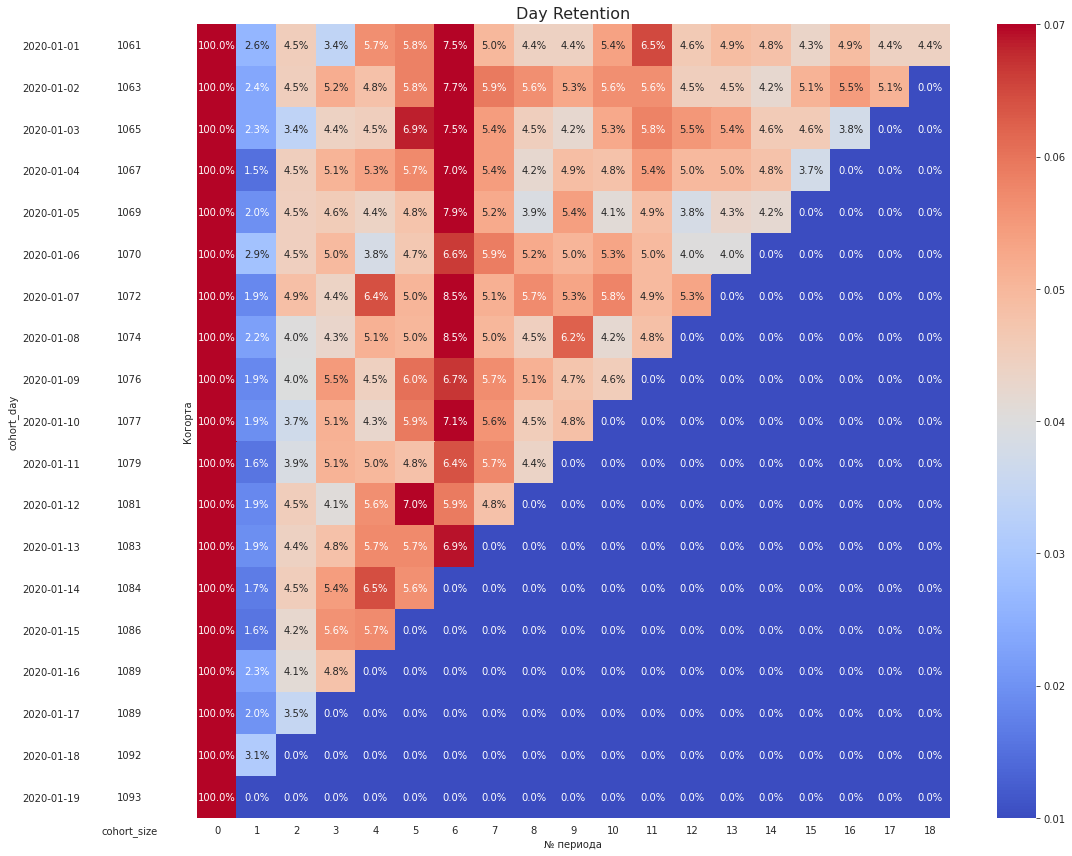

In [14]:
# Построим тепловую карту для визуализации
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    sns.heatmap(
        retention_matrix,
        mask=retention_matrix.isnull(),
        annot=True,
        fmt='.1%',
        cmap='coolwarm',
        vmin=0.01,
        vmax=0.07,
        ax=ax[1]
    )
    ax[1].set_title('Day Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')
    
    # Тепловая карта для размера когорты
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])
    
    fig.tight_layout()
    plt.show()

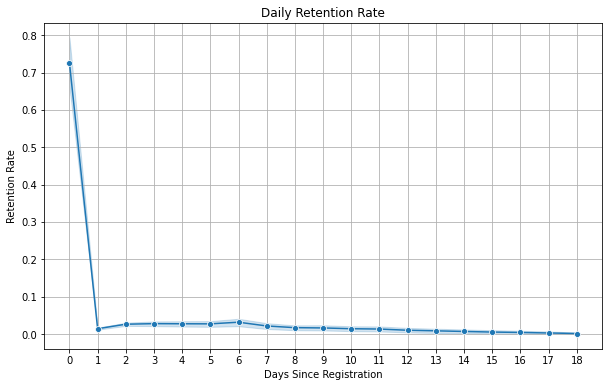

In [17]:
# Построим график для визуализации retention
plt.figure(figsize=(10, 6))
sns.lineplot(data=retention_melted, x='days_since_registration', y='retention_rate', marker='o')
plt.title('Daily Retention Rate')
plt.xlabel('Days Since Registration')
plt.ylabel('Retention Rate')
plt.xticks(range(0, retention_melted['days_since_registration'].max() + 1))
plt.grid()
plt.show()

Выводы:
* процент удержания достаточно низкий